# Evaluating BacalhauNet

## Outline
* [Load the RadioML 2018 Dataset](#load_dataset)
* [Define the BacalhauNet Model](#define_model)
    * [Load Pre-Trained Parameters](#load_trained_model)
* [Evaluate the Accuracy](#evaluate_accuracy)
* [Evaluate the Inference Cost](#evaluate_inference_cost)

In [1]:
# Import some general modules
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# Select which GPU to use (if available)

print(torch.__version__)

gpu = 0
if torch.cuda.is_available():
    torch.cuda.device(gpu)
    print("Using GPU %d" % gpu)
else:
    gpu = None
    print("Using CPU only")

1.7.1
Using GPU 0


# The RadioML 2018 Dataset <a id='load_dataset'></a>
This problem statement is based on the popular RadioML 2018.01A dataset provided by DeepSig. It is the latest in a series of modulation classification datasets ([deepsig.ai/datasets](https://www.deepsig.ai/datasets)) and contains samples of 24 digital and analog modulation types under various channel impairments and signal-to-noise ratios (SNRs). For more information on the dataset origins, we refer to the associated paper [Over-the-Air Deep Learning Based Radio Signal Classification](https://arxiv.org/pdf/1712.04578.pdf) by O’Shea, Roy, and Clancy.


The dataset comes in hdf5 format and exhibits the following structure:
- 24 modulations
- 26 SNRs per modulation (-20 dB through +30 dB in steps of 2)
- 4096 frames per modulation-SNR combination
- 1024 complex time-series samples per frame
- Samples as floating point in-phase and quadrature (I/Q) components, resulting in a (1024,2) frame shape
- 2.555.904 frames in total
 

## Download
The dataset is available here: **https://opendata.deepsig.io/datasets/2018.01/2018.01.OSC.0001_1024x2M.h5.tar.gz**

Since access requires a (straightforward) registration, you must download and extract it manually. It measures about 18 GiB in size (20 GiB uncompressed).

To access it from within this container, you can place it:
- A) Under the sandbox directory you launched this notebook from, which is mounted under "/workspace/sandbox".
- B) Anywhere, then set the environment variable `DATASET_DIR` before launching "run_docker.sh" to mount it under "/workspace/dataset".

You might notice that the dataset comes with a "classes.txt" file containing the alleged modulation labels. However, you should disregard the ordering of these labels due to a known issue ([github.com/radioML/dataset/issues/25](http://github.com/radioML/dataset/issues/25)). This notebook uses the corrected labels throughout.

In the following, we create the data loader and can inspect some frames to get an idea what the input data looks like.

In [3]:
# Check if dataset is present
import os.path
dataset_path = "/workspace/dataset/GOLD_XYZ_OSC.0001_1024.hdf5"
os.path.isfile(dataset_path)

True

In [4]:
# Prepare data loader
from torch.utils.data import Dataset, DataLoader
import h5py

class radioml_18_dataset(Dataset):
    def __init__(self, dataset_path):
        super(radioml_18_dataset, self).__init__()
        h5_file = h5py.File(dataset_path,'r')
        self.data = h5_file['X']
        self.mod = np.argmax(h5_file['Y'], axis=1) # comes in one-hot encoding
        self.snr = h5_file['Z'][:,0]
        self.len = self.data.shape[0]

        self.mod_classes = ['OOK','4ASK','8ASK','BPSK','QPSK','8PSK','16PSK','32PSK',
        '16APSK','32APSK','64APSK','128APSK','16QAM','32QAM','64QAM','128QAM','256QAM',
        'AM-SSB-WC','AM-SSB-SC','AM-DSB-WC','AM-DSB-SC','FM','GMSK','OQPSK']
        self.snr_classes = np.arange(-20., 32., 2) # -20dB to 30dB

        # do not touch this seed to ensure the prescribed train/test split!
        np.random.seed(2018)
        train_indices = []
        test_indices = []
        for mod in range(0, 24): # all modulations (0 to 23)
            for snr_idx in range(0, 26): # all SNRs (0 to 25 = -20dB to +30dB)
                # 'X' holds frames strictly ordered by modulation and SNR
                start_idx = 26*4096*mod + 4096*snr_idx
                indices_subclass = list(range(start_idx, start_idx+4096))
                
                # 90%/10% training/test split, applied evenly for each mod-SNR pair
                split = int(np.ceil(0.1 * 4096)) 
                np.random.shuffle(indices_subclass)
                train_indices_subclass = indices_subclass[split:]
                test_indices_subclass = indices_subclass[:split]
                
                # you could train on a subset of the data, e.g. based on the SNR
                # here we use all available training samples
                if snr_idx >= 0:
                    train_indices.extend(train_indices_subclass)
                test_indices.extend(test_indices_subclass)
                
        self.train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        self.test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    def __getitem__(self, idx):
        # transpose frame into Pytorch channels-first format (NCL = -1,2,1024)
        return self.data[idx].transpose(), self.mod[idx], self.snr[idx]

    def __len__(self):
        return self.len

dataset = radioml_18_dataset(dataset_path)

# Define the BacalhauNet Model <a id='define_model'></a>

In [5]:
from bacalhaunetv1_quant import bacalhaunetv1 as load_bacalhau

model = load_bacalhau(in_samples=1024, in_channels=2, num_classes=24)

# Load a Trained Model <a id='load_trained_model'></a>

In [6]:
# Load trained parameters
#savefile = "models/bacalhaunet_FINAL.pth"
#savefile = "models/old/bacalhaunet_1st_prune.pth"
savefile = "jose/models/BacalhauNetV1_Quant_3rd_prune.pth"
saved_state = torch.load(savefile, map_location=torch.device("cpu"))
model.load_state_dict(saved_state)
if gpu is not None:
    model = model.cuda()

RuntimeError: CUDA error: out of memory

# Evaluate the Accuracy <a id='evaluate_accuracy'></a>
The following cells visualize the test accuracy across different modulations and signal-to-noise ratios. Submissions for this problem statement must reach an overall accuracy of at least **56.0%**, so this should give you an idea what makes up this figure.

In [7]:
# Set up a fresh test data loader
batch_size = 1024
dataset = radioml_18_dataset(dataset_path)
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler=dataset.test_sampler)

In [8]:
# Run inference on validation data
y_exp = np.empty((0))
y_snr = np.empty((0))
y_pred = np.empty((0,len(dataset.mod_classes)))
model.eval()
with torch.no_grad():
    for data in tqdm(data_loader_test, desc="Batches"):
        inputs, target, snr = data
        if gpu is not None:
            inputs = inputs.cuda()
        output = model(inputs)
        y_pred = np.concatenate((y_pred,output.cpu()))
        y_exp = np.concatenate((y_exp,target))
        y_snr = np.concatenate((y_snr,snr))

Batches:   0%|          | 0/250 [00:00<?, ?it/s]

Overall Accuracy across all SNRs: 0.585765


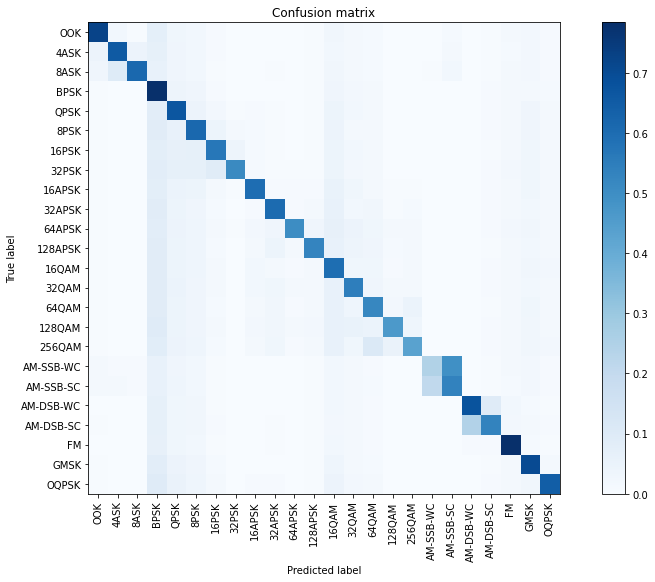

In [9]:
# Plot overall confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

conf = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
confnorm = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
for i in range(len(y_exp)):
    j = int(y_exp[i])
    k = int(np.argmax(y_pred[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(dataset.mod_classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plt.figure(figsize=(12,8))
plot_confusion_matrix(confnorm, labels=dataset.mod_classes)

cor = np.sum(np.diag(conf))
ncor = np.sum(conf) - cor
print("Overall Accuracy across all SNRs: %f"%(cor / (cor+ncor)))

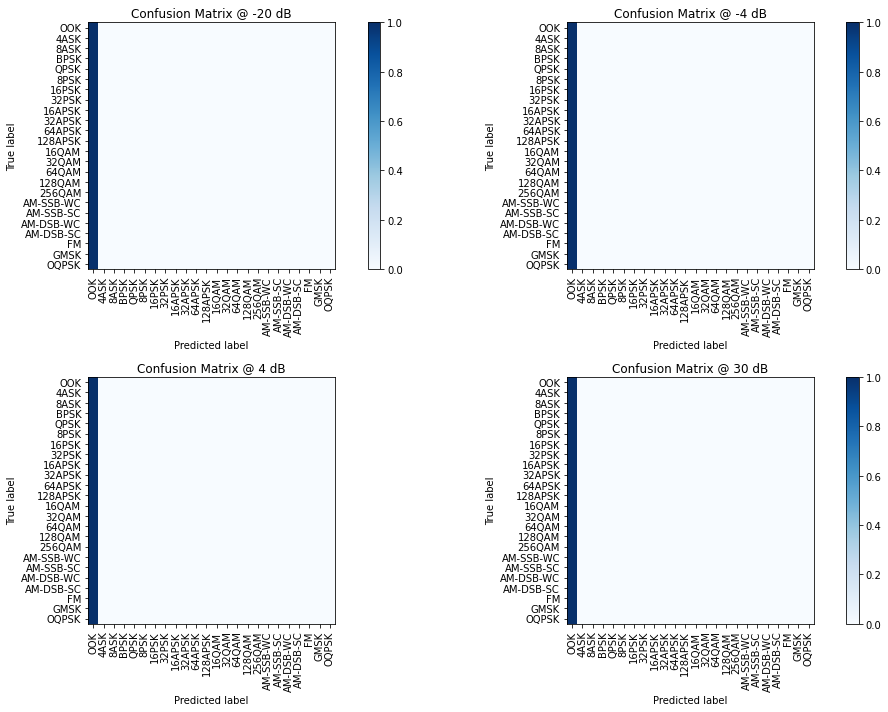

In [10]:
# Plot confusion matrices at 4 different SNRs
snr_to_plot = [-20,-4,+4,+30]
plt.figure(figsize=(16,10))
acc = []
for snr in dataset.snr_classes:
    # extract classes @ SNR
    indices_snr = (y_snr == snr).nonzero()
    y_exp_i = y_exp[indices_snr]
    y_pred_i = y_pred[indices_snr]
 
    conf = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    confnorm = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    for i in range(len(y_exp_i)):
        j = int(y_exp_i[i])
        k = int(np.argmax(y_pred_i[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(dataset.mod_classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
 
    if snr in snr_to_plot:
        plot, = np.where(snr_to_plot == snr)[0]
        plt.subplot(221+plot)
        plot_confusion_matrix(confnorm, labels=dataset.mod_classes, title="Confusion Matrix @ %d dB"%(snr))
 
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    acc.append(cor/(cor+ncor))

Accuracy @ highest SNR (+30 dB): 0.041667
Accuracy overall: 0.041667


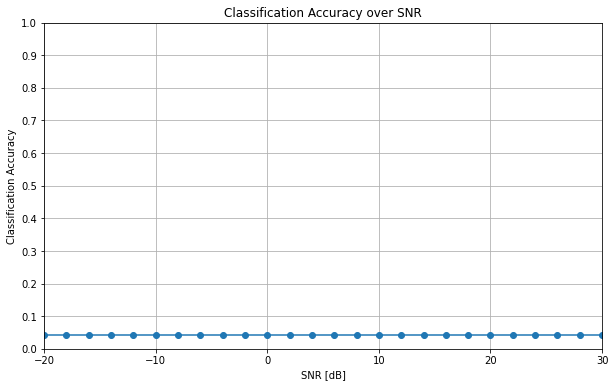

In [11]:
# Plot accuracy over SNR
plt.figure(figsize=(10,6))
plt.plot(dataset.snr_classes, acc, marker='o')
plt.xlabel("SNR [dB]")
plt.xlim([-20, 30])
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Classification Accuracy over SNR")
plt.grid()
plt.title("Classification Accuracy over SNR");

print("Accuracy @ highest SNR (+30 dB): %f"%(acc[-1]))
print("Accuracy overall: %f"%(np.mean(acc)))

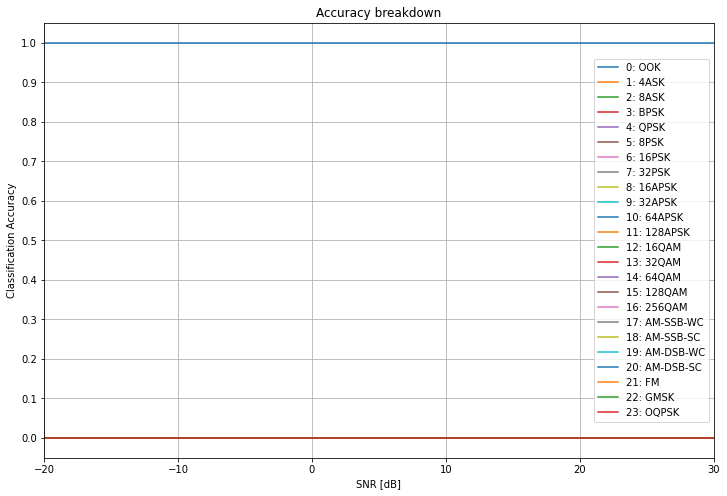

In [12]:
# Plot accuracy per modulation
accs = []
for mod in range(24):
    accs.append([])
    for snr in dataset.snr_classes:
        indices = ((y_exp == mod) & (y_snr == snr)).nonzero()
        y_exp_i = y_exp[indices]
        y_pred_i = y_pred[indices]
        cor = np.count_nonzero(y_exp_i == np.argmax(y_pred_i, axis=1))
        accs[mod].append(cor/len(y_exp_i))
        
# Plot accuracy-over-SNR curve
plt.figure(figsize=(12,8))
for mod in range(24):
    if accs[mod][25] < 0.95 or accs[mod][0] > 0.1:
        color = None
    else:
        color = "black"
    plt.plot(dataset.snr_classes, accs[mod], label=str(mod) + ": " + dataset.mod_classes[mod], color=color)
plt.xlabel("SNR [dB]")
plt.xlim([-20, 30])
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Accuracy breakdown")
plt.grid()
plt.legend();

# Evaluate the Inference Cost <a id='evaluate_inference_cost'></a>

First, we have to export the model to Brevita's quantized variant of the ONNX interchange format. **All submissions must correctly pass through this export flow and provide the resulting .onnx file**. Any `TracerWarning` can be safely ignored.

In [13]:
from brevitas.export.onnx.generic.manager import BrevitasONNXManager

export_onnx_path = "models/model_export.onnx"
final_onnx_path = "models/model_final.onnx"
cost_dict_path = "models/model_cost.json"

BrevitasONNXManager.export(model.cpu(), input_t=torch.randn(1, 2, 1024), export_path=export_onnx_path);

/opt/conda/lib/python3.8/site-packages/brevitas/quant_tensor/__init__.py:74: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  training = torch.tensor(training, dtype=torch.bool)
/opt/conda/lib/python3.8/site-packages/brevitas/quant_tensor/__init__.py:72: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  signed = torch.tensor(signed, dtype=torch.bool)
/opt/conda/lib/python3.8/site-packages/brevitas/quant_tensor/__init__.py:80: TracerWarning: Converting a tensor to a Python number might

Now we use our analysis tool, which is part of [finn-base](https://github.com/Xilinx/finn-base), to determine the inference cost. It reports the number of output activation variables (`mem_o`), weight parameters (`mem_w`), and multiply-accumulate operations (`op_mac`) for each data type. These are used to calculate the total number of activation bits, weight bits, and bit-operations (BOPS).

If the report shows any unsupported operations, for instance because you implemented custom layers, you should check with the rules on the problem statement [website](http://bit.ly/brevitas-radioml-challenge-21) and consider to contact the organizers.

In [14]:
from finn.util.inference_cost import inference_cost
import json

inference_cost(export_onnx_path, output_json=cost_dict_path, output_onnx=final_onnx_path,
               preprocess=True, discount_sparsity=True)

Inference cost for models/model_export.onnx
{
  "discount_sparsity": true,
  "mem_o_FLOAT32": 93208.0,
  "mem_w_SCALEDINT6": 9318.0,
  "op_mac_FLOAT32_SCALEDINT6": 147456.0,
  "op_mac_SCALEDINT8_SCALEDINT6": 28800.0,
  "op_mac_SCALEDUINT6_SCALEDINT6": 1867776.0,
  "total_bops": 96933888.0,
  "total_mem_o_bits": 2982656.0,
  "total_mem_w_bits": 55908.0,
  "unsupported": "set()"
}


The call to `ìnference_cost()` cleans up the model by inferring shapes and datatypes, folding constants, etc. We visualize the pre-processed ONNX model using [Netron](https://netron.app/).

In [15]:
import os
import netron
from IPython.display import IFrame

def showInNetron(model_filename):
    localhost_url = os.getenv("LOCALHOST_URL")
    netron_port = os.getenv("NETRON_PORT")
    netron.start(model_filename, address=("0.0.0.0", int(netron_port)))
    return IFrame(src="http://%s:%s/" % (localhost_url, netron_port), width="100%", height=400)

showInNetron(final_onnx_path)

Serving 'models/model_final.onnx' at http://0.0.0.0:8081


Finally, we compute the inference cost score, normalized to the baseline 8-bit VGG10 defined in this notebook. **Submissions will be judged based on this score.**

In [16]:
with open(cost_dict_path, 'r') as f:
    inference_cost_dict = json.load(f)

bops = int(inference_cost_dict["total_bops"])
w_bits = int(inference_cost_dict["total_mem_w_bits"])

bops_baseline = 807699904
w_bits_baseline = 1244936

score = 0.5*(bops/bops_baseline) + 0.5*(w_bits/w_bits_baseline)
print("Normalized inference cost score: %f" % score)

Normalized inference cost score: 0.082460
